In [2]:
import networkx as nx

In [3]:
G = nx.read_gexf("./data/graph.gexf")

## Find how many packages are dependent on the analyzed subset
A subset of packages are further analyzed in terms of evaluating the chances of a successful attack/takeover by an attacker. We do this cover analysis to check how big the impact on the whole ecosystem actually is by the subset. This does not say anything about the chances of infecting as much packages as possible. It rather tells us how good the selection of analyzed packages is. 

In [4]:
import csv
import matplotlib.pyplot as plt

In [61]:
G_reversed = nx.reverse(G)

for node in G_reversed.nodes():
    G_reversed.nodes[node]['covered'] = False

def dfs(node):
    if G_reversed.nodes[node]['covered']:
        return
    G_reversed.nodes[node]['covered'] = True
    for neighbor in G_reversed.neighbors(node):
        dfs(neighbor)

with open('./data/gh_packages.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        name = row['pkg_name']
        if not name:
            continue
        G_reversed.nodes[name]['analyzed'] = True
        dfs(name)

We now gradually delete all packages from the graph which have overall less impact measured by the `avg_daily` pull count attribute. This enables us to show how good the coverage is for increasingly more impactful packages.

In [62]:
covered_percentages = []
node_counts = []
steps = 60
avg_daily_thresholds = list(range(0, 1201, steps))
for min_avg_daily in avg_daily_thresholds:
    nodes_to_remove = [node for node, data in G_reversed.nodes(data=True) if data.get('avg_daily', 0) < min_avg_daily and data.get('analyzed', False) == False]
    G_reversed.remove_nodes_from(nodes_to_remove)
    total_nodes = G_reversed.number_of_nodes()
    node_counts.append(total_nodes)
    covered_count = sum(1 for node in G_reversed.nodes() if G_reversed.nodes[node]['covered'])
    covered_percentages.append(covered_count / total_nodes * 100)

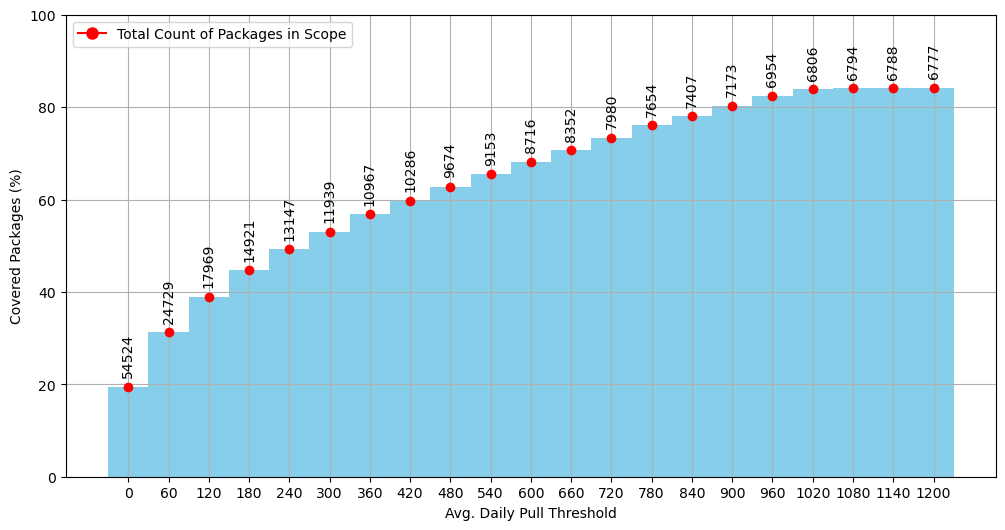

In [63]:
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_daily_thresholds, covered_percentages, width=steps, color='skyblue')
plt.xlabel('Avg. Daily Pull Threshold')
plt.ylabel('Covered Packages (%)')
plt.xticks(avg_daily_thresholds)
plt.grid()
for bar, count in zip(bars, node_counts):
    yval = bar.get_height()
    plt.plot(bar.get_x() + bar.get_width()/2, yval, marker='o', markersize=6, color='red')
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(count), ha='center', va='bottom', rotation=90)
plt.plot([], [], marker='o', markersize=8, color='red', label='Total Count of Packages in Scope')
plt.legend()
plt.ylim(0, 100)
plt.show()

*Interpreting the results:* What this plot essentially tells us, is that from around 1000 average pulls minimum, the coverage of "are we able to reach other packages?" stagnates at 85%.